In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install python-dotenv==0.19.0 tqdm==4.62.2 numpy Pillow==7.0.0 matplotlib==3.4.3 opencv-python==4.6.0.66 opencv-python-headless==4.6.0.66 matplotlib
!pip install scikit-learn==0.24.2 torch==1.12.1 torchvision==0.13.1 pytorch-ignite segmentation-models-pytorch==0.2.0 albumentations==1.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 2.9 MB/s 
     |████████████████████████████████| 2.1 MB 28.1 MB/s 
     |████████████████████████████████| 10.3 MB 42.9 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 7.0.0 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 88.1 MB/s 
     |████████████████████████████████| 264 kB 50.8 MB/s 
     |████████████████████████████████| 87 kB 5.2 MB/s 
     |████████████████████████████████| 98 kB 7.8 MB/s 
     |████████████████████████████████| 376 kB 48.4 MB/s 
     |████████████████████████████████| 58 kB 5.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12420 sha256=10a1732d9d1a156b14184a3d2ef354bbc6e9832decc9f1d04d10c61cf45e2938
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=f6a71744f2975e29daefab81accdf6f1c7ea35e0a9cd19c81ecc77e103c2317c
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4

In [ ]:
## Импорт необходимых библиотек
import torch
import torch.nn as nn

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Metric
from ignite.engine import _prepare_batch

from tqdm import tqdm

import json
import base64
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from typing import Callable, Tuple, Dict, Any, List, Sequence, Iterator, Optional
from collections import defaultdict
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn, FastRCNNPredictor

## Детекция дверей

### Вспомогательные функции

In [ ]:
class DetectionTrainer:

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                 device: str, metric_functions: List[Tuple[str, Callable]] = [],
                 callbacks: List[Callable[[nn.Module, int], None]] = [], epoch_number: int = 0):
        self.model = model
        self.optimizer = optimizer

        self.device = device

        self.metric_functions = metric_functions
        self.callbacks = callbacks

        self.epoch_number = epoch_number

    @torch.no_grad()
    def evaluate_batch(self, val_iterator: Iterator, eval_on_n_batches: int) -> Optional[Dict[str, float]]:
        predictions = []
        targets = []

        for real_batch_number in range(eval_on_n_batches):
            try:
                xs, ys = next(val_iterator)

                xs = torch.tensor(xs, device=self.device)
                ys = [{key: torch.tensor(y[key], device=self.device) for key in y} for y in ys]
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.eval()(xs)

            for y_pred, y_true in zip(ys_pred, ys):
                predictions.append({key: y_pred[key].cpu().numpy() for key in y_pred})
                targets.append({key: y_true[key].cpu().numpy() for key in y_true})

        metrics = {}

        predictions_tensor = []
        targets_tensor = []

        for y_pred, y_true in zip(predictions, targets):
            predictions_tensor.append({key: torch.tensor(y_pred[key], device=self.device) for key in y_pred})
            targets_tensor.append({key: torch.tensor(y_true[key], device=self.device) for key in y_true})

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    @torch.no_grad()
    def evaluate(self, val_loader: DataLoader, eval_on_n_batches: int = 1) -> Dict[str, float]:
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        while True:
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit_batch(self, train_iterator: Iterator, update_every_n_batches: int) -> Optional[Dict[str, float]]:
        self.optimizer.zero_grad()

        predictions = []
        targets = []

        for real_batch_number in range(update_every_n_batches):
            try:
                xs, ys = next(train_iterator)
                xs = torch.tensor(xs, device=self.device)
                ys = [{key: torch.tensor(y[key], device=self.device) for key in y} for y in ys]
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            loss = sum(self.model.train()(xs, ys).values())

            (loss / update_every_n_batches).backward()

            with torch.no_grad():
                ys_pred = self.model.eval()(xs)

                for y_pred, y_true in zip(ys_pred, ys):
                    predictions.append({key: y_pred[key].cpu().numpy() for key in y_pred})
                    targets.append({key: y_true[key].cpu().numpy() for key in y_true})

        self.optimizer.step()

        metrics = {}

        predictions_tensor = []
        targets_tensor = []

        for y_pred, y_true in zip(predictions, targets):
            predictions_tensor.append({key: torch.tensor(y_pred[key], device=self.device) for key in y_pred})
            targets_tensor.append({key: torch.tensor(y_true[key], device=self.device) for key in y_true})

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    def fit_epoch(self, train_loader: DataLoader, update_every_n_batches: int = 1) -> Dict[str, float]:
        metrics_sum = defaultdict(float)
        num_batches = 0

        train_iterator = iter(train_loader)

        while True:
            batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit(self, train_loader: DataLoader, num_epochs: int,
            val_loader: DataLoader = None, update_every_n_batches: int = 1
            ) -> Dict[str, np.ndarray]:
        summary = defaultdict(list)

        def save_metrics(metrics: Dict[str, float], postfix: str = '') -> None:
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f'{metric}{postfix}', metrics[metric]

                summary[metric_name].append(metric_value)

                print(f"{metric_name}: {metric_value}, Epoch: {self.epoch_number}")

        for _ in tqdm(range(num_epochs - self.epoch_number), initial=self.epoch_number, total=num_epochs):
            self.epoch_number += 1

            train_metrics = self.fit_epoch(train_loader, update_every_n_batches)

            with torch.no_grad():
                save_metrics(train_metrics, postfix='_train')

                if val_loader is not None:
                    test_metrics = self.evaluate(val_loader)
                    save_metrics(test_metrics, postfix='_test')

                with torch.no_grad():
                    for callback in self.callbacks:
                        callback(self.model, self.epoch_number)

        summary = {metric: np.array(summary[metric]) for metric in summary}

        return summary

### Инициализация модели обучения и функций для подсчета метрик качества обучения нейросетей

In [ ]:
def initialize_model(num_classes: int,
                     min_size: int, max_size: int,
                     image_mean: Sequence[float], image_std: Sequence[float],
                     device: str = None) -> torch.nn.Module:
    pretrained_model = fasterrcnn_resnet50_fpn(pretrained=False, min_size=min_size, max_size=max_size,
                                               image_mean=image_mean, image_std=image_std)
    num_predictor_features = pretrained_model.roi_heads.box_head.fc7.out_features
    pretrained_model.roi_heads.box_predictor = FastRCNNPredictor(num_predictor_features, num_classes)

    return pretrained_model.to(device)


def compute_iou(box1: torch.tensor, box2: torch.tensor) -> torch.tensor:
    x1 = max(box1[0], box2[0])
    x2 = min(box1[2], box2[2])
    y1 = max(box1[1], box2[1])
    y2 = min(box1[3], box2[3])

    if x2 - x1 < 0 or y2 - y1 < 0:
        return 0

    intersection = (x2 - x1) * (y2 - y1)
    sum_ = ((box1[2] - box1[0]) * (box1[3] - box1[1]) +
            (box2[2] - box2[0]) * (box2[3] - box2[1]))

    iou = intersection / (sum_ - intersection)

    return iou.item()


class MeanAveragePrecision:

    def __init__(self, num_conf: int = 11):
        self.num_conf = num_conf

    @staticmethod
    def is_true(box: torch.tensor, label: int,
                y_true: Dict[str, torch.tensor],
                iou_thresh: float = 0.5) -> bool:
        num_true = len(y_true['boxes'])

        for i in range(num_true):
            if label == y_true['labels'][i]:
                if compute_iou(box, y_true['boxes'][i]) > iou_thresh:
                    return True
        return False

    @staticmethod
    def compute_map_given_conf(y_preds: List[Dict[str, torch.tensor]],
                               y_trues: List[Dict[str, torch.tensor]],
                               conf: float) -> float:
        num_pos = defaultdict(int)
        num_true_pos = defaultdict(int)

        for y_pred, y_true in zip(y_preds, y_trues):

            num_pred = len(y_pred['boxes'])

            for i in range(num_pred):
                if y_pred['scores'][i] > conf:
                    label = y_pred['labels'][i]
                    num_pos[label] += 1

                    if MeanAveragePrecision.is_true(y_pred['boxes'][i], y_pred['labels'][i], y_true):
                        num_true_pos[label] += 1

        all_classes_sum = sum(num_true_pos[lbl] / num_pos[lbl] for lbl in num_pos)

        try:
            precision = all_classes_sum / len(num_pos)
        except ZeroDivisionError:
            precision = 0

        return precision

    def __call__(self, y_pred: List[Dict[str, torch.tensor]],
                 y_true: List[Dict[str, torch.tensor]]) -> float:
        assert len(y_pred) == len(y_true)

        map_sum = 0

        for conf in np.linspace(0, 1, self.num_conf):
            map_sum += self.compute_map_given_conf(y_pred, y_true, conf)

        return torch.tensor(map_sum / self.num_conf)


def minimum_bounding_box(points: List[List[float]]) -> Tuple[float, float, float, float]:
    x_min = min(p[0] for p in points)
    y_min = min(p[1] for p in points)
    x_max = max(p[0] for p in points)
    y_max = max(p[1] for p in points)

    return x_min, y_min, x_max, y_max


### Классы, для формирования датасетов(для обучения и для тестирования)

In [ ]:
class DataRetriever:

    def __init__(self,
                 dataset_path: str):
        super().__init__()

        self.dataset_path = dataset_path
        self.samples_paths = self.load_paths()
        print(f'Found {len(self.samples_paths)} samples')

    def remove_path(self, idx):
        del self.samples_paths[idx]

    def load_paths(self) -> List[str]:
        samples_paths = []

        for object_ in tqdm(os.listdir(self.dataset_path)):
            ext = object_.split(".")[-1]

            if ext != 'json':
                continue

            samples_paths.append(self.dataset_path + "/" + object_)

        return samples_paths

    def num_paths(self) -> int:
        return len(self.samples_paths)


class PLRCDataset(Dataset):

    def __init__(self, data_retriever,
                 class_ids: Dict,
                 transform: A.BasicTransform = None,
                 remove_unannotated: bool = False):
        self.data_retriever = data_retriever

        self.class_ids = class_ids

        self.transform = transform

        if remove_unannotated:
            print("Removing unannotated samples")
            num_removed = self.remove_unannotated_paths()
            print(f"Removed {num_removed} unannotated samples")

    def make_layout(self, shapes: List[Dict], image_size: Tuple[int, int]) -> Dict[str, np.ndarray]:
        shapes = self.select_shapes(shapes)

        boxes = []
        labels = []

        for shape in shapes:
            if len(shape['points']) < 2:
                continue

            label = shape['label']

            if label not in self.class_ids:
                continue

            x1, y1, x2, y2 = minimum_bounding_box(shape['points'])

            x1 = max(x1, 0)
            y1 = max(y1, 0)
            x2 = min(x2, image_size[1] - 1)
            y2 = min(y2, image_size[0] - 1)

            if x1 == x2 or y1 == y2:
                continue

            boxes.append((x1, y1, x2, y2))
            labels.append(self.class_ids[label])

        if len(boxes) > 0:
            boxes = np.array(boxes)
            labels = np.array(labels, dtype=np.int64)
        else:
            boxes = np.empty((0, 4))
            labels = np.empty(0, dtype=np.int64)

        return {'boxes': boxes, 'labels': labels}

    @staticmethod
    def select_shapes(shapes: List[Dict]) -> List[Dict]:
        good_shapes = []

        for shape in shapes:
            if shape['shape_type'] not in {'polygon', 'rectangle'} or len(shape['points']) < 2:
                continue

            good_shapes.append(shape)

        return good_shapes

    def remove_unannotated_paths(self) -> int:
        counter = 0

        for i in tqdm(range(len(self) - 1, -1, -1)):
            _, y = self[i]
            if len(y['boxes']) == 0:
                self.data_retriever.remove_path(i)
                counter += 1

        return counter

    @staticmethod
    def decode_image(encoded_image: str) -> np.ndarray:
        bytearray_ = np.asarray(bytearray(base64.b64decode(encoded_image)), dtype=np.uint8)
        return cv2.imdecode(bytearray_, cv2.IMREAD_COLOR).astype(np.float32) / 255

    def read_sample(self, json_path) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        with open(json_path, 'r') as f:
            json_contents = json.load(f)

        image = self.decode_image(json_contents['imageData'])
        layout = self.make_layout(json_contents['shapes'], image.shape[:2])

        return image, layout

    def __getitem__(self, idx):
        sample_path = self.data_retriever.samples_paths[idx]

        x, y = self.read_sample(sample_path)

        if self.transform is not None:
            transformed = self.transform(image=x, bboxes=y['boxes'], labels=y['labels'])
            x, y['boxes'], y['labels'] = transformed['image'], transformed['bboxes'], transformed['labels']

        return x, y

    def __len__(self):
        return self.data_retriever.num_paths()


class DatasetPart(Dataset):

    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.BasicTransform = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> Any:
        x, y = self.dataset[self.indices[idx]]

        if self.transform is not None:
            transformed = self.transform(image=x, bboxes=y['boxes'], labels=y['labels'])
            x, y['boxes'], y['labels'] = transformed['image'], transformed['bboxes'], transformed['labels']

        return x, y

    def __len__(self) -> int:
        return len(self.indices)


### Объявляем конфиг для object_detection

In [ ]:
config = {
  "dataset_path": "/content/drive/MyDrive/object_detection",
  "model_log_interval": 1,
  "data": {
    "class_ids": {
      "door": 1,
      "door_balcony": 1
    }
  },
  "model": {
    "image_size": 512
  },
  "training": {
    "num_epochs": 50,
    "batch_size": 16,
    "update_every_n_batches": 1,
    "device": "cpu",
    "learning_rate": 1e-4,
    "num_workers": 0
  }
}

### Код обучения

In [ ]:
# https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/
# https://github.com/DevashishPrasad/CascadeTabNet
def make_transforms(config: Dict[str, Any]) -> Dict[str, Callable]:
    size = config['model']['image_size']

    train_list = [A.LongestMaxSize(size),
                  A.PadIfNeeded(size, size, border_mode=cv2.BORDER_REPLICATE),
                  ToTensorV2()]
    eval_list = [A.LongestMaxSize(size),
                 A.PadIfNeeded(size, size, border_mode=cv2.BORDER_REPLICATE),
                 ToTensorV2()]

    return {'train': A.Compose(train_list, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])),
            'test': A.Compose(eval_list, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))}


def make_datasets(transforms, config: Dict[str, Any]) -> Dict[str, Dataset]:
    all_data_retriever = DataRetriever(f"{config['dataset_path']}")

    all_data_dataset = PLRCDataset(all_data_retriever, config['data']['class_ids'], remove_unannotated=True)

    train_indices, test_indices = train_test_split(range(len(all_data_dataset)), test_size=0.3)

    return {'train': DatasetPart(all_data_dataset, train_indices, transform=transforms['train']),
            'test': DatasetPart(all_data_dataset, test_indices, transform=transforms['test'])}


def make_loaders(datasets, config: Dict[str, Any]):
    def collate_fn(samples):
        xs, ys = list(zip(*samples))

        for y in ys:
            if len(y['boxes']) == 0:
                y['boxes'] = np.empty((0, 4), dtype=np.float32)
            else:
                y['boxes'] = np.array(y['boxes'], dtype=np.float32)

            y['labels'] = np.array(y['labels'], dtype=np.int64)

        return torch.stack(xs), ys

    loaders = {}

    for name in datasets:
        loaders[name] = DataLoader(datasets[name], config['training']['batch_size'],
                                   num_workers=config['training']['num_workers'],
                                   shuffle=True, collate_fn=collate_fn)

    return loaders


def make_save_model_callback(log_interval: int):
    def save_model(model, epoch):
        if epoch % log_interval != 0:
            return
        torch.save(model.state_dict(), f"/content/drive/MyDrive/model_obj_door")

    return save_model

In [ ]:
if __name__ == '__main__':
    transforms = make_transforms(config)
    datasets = make_datasets(transforms, config)
    data_loaders = make_loaders(datasets, config)
    
    model = initialize_model(1 + max(config['data']['class_ids'].values()),
                             config['model']['image_size'], config['model']['image_size'], [0, 0, 0], [1, 1, 1],
                             config['training']['device'])
    optimizer = torch.optim.Adam(model.parameters(), config['training']['learning_rate'])

    metrics = [('mAP', MeanAveragePrecision())]

    trainer = DetectionTrainer(model, optimizer, metric_functions=metrics,
                               callbacks=[make_save_model_callback(config['model_log_interval'])],
                               device=config['training']['device'])

    trainer.fit(data_loaders['train'], config['training']['num_epochs'], val_loader=data_loaders['test'])

### Вывод конечного результата

In [ ]:
pip install matplotlib==3.1.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


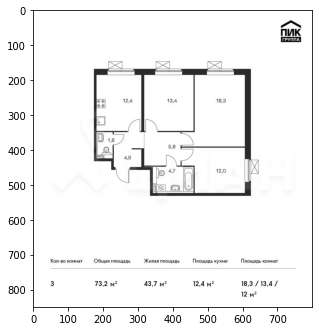

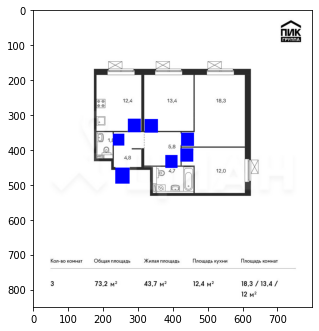

In [ ]:
def draw_with_boxes(image: np.ndarray,
                    preds: Dict[str, np.ndarray] = None,
                    conf_threshold=0.5) -> np.ndarray:

    image = image.copy()

    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    font_scale = 0.7
    line_type = 1
    label_padding = 5

    num_boxes = len(preds['boxes'])

    for i in range(num_boxes):
        if preds['scores'][i] < conf_threshold:
            continue
        x_min, y_min, x_max, y_max = preds['boxes'][i]

        cv2.rectangle(img=image,
                      pt1=(int(x_min), int(y_min)),
                      pt2=(int(x_max), int(y_max)),
                      color=(0, 0, 255),
                      thickness=-1)

    return image

##Загрузка тестового изображения
image = cv2.imread(f"/content/drive/MyDrive/test.png").astype(np.float32) / 255

## Вывод исходного изображения
plt.figure(figsize=(12, 12))
plt.subplot(211)
im1 = plt.imshow(image)

## Применение модели
class_ids = config['data']['class_ids']
reverse_classes_map = {v: k for k, v in class_ids.items()}
bytearray_ = np.asarray(bytearray(image), dtype=np.uint8)
x = image
transform = ToTensorV2()
model = initialize_model(1 + max(config['data']['class_ids'].values()),
                             config['model']['image_size'], config['model']['image_size'], [0, 0, 0], [1, 1, 1],
                             config['training']['device'])
model.load_state_dict(torch.load("/content/drive/MyDrive/model_obj_door",  map_location=torch.device('cpu')))
x = transform(image=x)['image']
with torch.no_grad():
  y_pred = model.eval()([torch.tensor(x, device=config['training']['device'])])[0]
  y_pred = {key: y_pred[key].cpu().numpy() for key in y_pred}
  y_pred['labels'] = np.array([reverse_classes_map[label] for label in y_pred['labels']])

  x = torch.moveaxis(x, 0, -1).cpu().numpy()
  x = np.ascontiguousarray(255 * x, dtype=np.uint8)

image_with_boxes = draw_with_boxes(x, y_pred)

## Вывод реузультирующего изображения
plt.figure(figsize=(12, 12))
plt.subplot(212)
im1 = plt.imshow(image_with_boxes)
